# **MNIST Handwritten Digits Classification**
A FFNN (Feed Forward Neural Network) and CNN (Convolutional Nerual Network) have been modeled

## Import required packages

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

## Defining our Transforms

In [ ]:
transform=transforms.Compose([transforms.ToTensor()])

## Gathering the train and test data


In [ ]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transform)
test_data=datasets.MNIST('data',train=False,download=True,transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 103000174.02it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 90738347.43it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29658261.63it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11774121.61it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

## Defining our Train, Valid and Test Dataloaders

In [ ]:
valid_size=0.2

# IMPORTANT
batch_size=20

num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))  #splitting the indices
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)

In [ ]:
# This is for debugging
train_idx.__len__(),valid_idx.__len__()

(48000, 12000)

In [ ]:
# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [ ]:
# checking our data
dataiter = iter(train_loader)
images,labels = next(dataiter)
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch

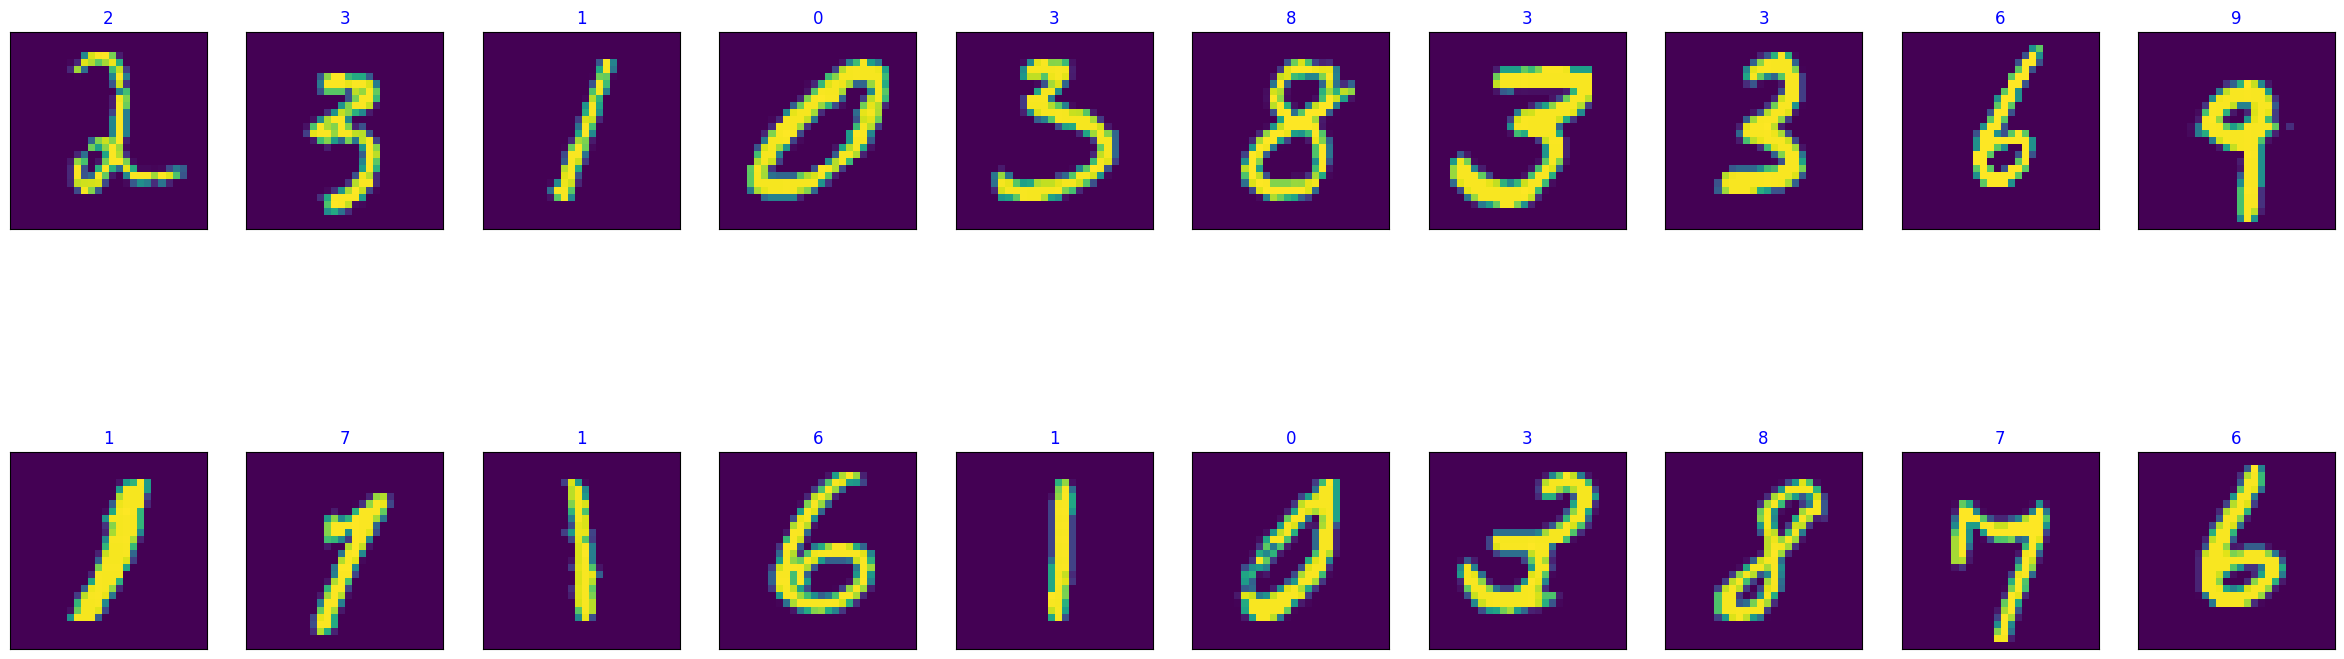

In [ ]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue') #setting label as the plot title

## Defining our Neural Net Architecture

In [ ]:

# Model 1 : This model has dropout set to a certain value
# NOTE : When we want to use dropout we ensure we run train() method on our model --- during training , if not required we should use eval() method --- validation and testing
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1 = nn.Linear(784,512) #input size: 28x28=784
        self.fc2 = nn.Linear(512,256)
        self.out = nn.Linear(256,10) #total 10 classes

        # Dropout probability - set for avoiding overfitting
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.out(x)
        return x

class convNet(nn.Module):
  def __init__(self):
    super(convNet,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1 = nn.Linear(7*7*32,512)
    self.fc2 = nn.Linear(512,256)
    self.out = nn.Linear(256,10)
    self.dropout = nn.Dropout(0.2)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,7*7*32)
    x = self.dropout(x)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.out(x)
    return x


In [ ]:
model_1=FNet()
model_2=convNet()

def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model_1.apply(weight_init_normal),model_2.apply(weight_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()

print(model_1,'\n\n\n\n',model_2,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  True


## Defining our Loss Function

In [ ]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()  (negative log likelihood loss)
criterion = nn.CrossEntropyLoss()

## Training and Validation Phase

In [ ]:
def trainNet(model,lr):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)

    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=20

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels = images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels = images.cuda(),labels.cuda()
            output = model(images)
            loss = criterion(output,labels)
            valid_loss += loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z = type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)

In [ ]:
m1_loss=trainNet(model_1,0.001)


Epoch : 1	Training Loss : 0.23898803001783867	Validation Loss : 0.12228497344263209
Validation loss decreased from : inf ----> 0.12228497344263209 ----> Saving Model.......

Epoch : 2	Training Loss : 0.11626345107290338	Validation Loss : 0.09466571065053965
Validation loss decreased from : 0.12228497344263209 ----> 0.09466571065053965 ----> Saving Model.......

Epoch : 3	Training Loss : 0.08710527058073543	Validation Loss : 0.09681711699403725

Epoch : 4	Training Loss : 0.07437736523391852	Validation Loss : 0.08633302693087899
Validation loss decreased from : 0.09466571065053965 ----> 0.08633302693087899 ----> Saving Model.......

Epoch : 5	Training Loss : 0.0644109517139672	Validation Loss : 0.10403003196622497

Epoch : 6	Training Loss : 0.05349882481134955	Validation Loss : 0.09699459988408876

Epoch : 7	Training Loss : 0.04804572814515259	Validation Loss : 0.09554613300573862

Epoch : 8	Training Loss : 0.04801859647834147	Validation Loss : 0.09672963299393254

Epoch : 9	Training Lo

In [ ]:
m1_loss

{'train': [0.23898803001783867,
  0.11626345107290338,
  0.08710527058073543,
  0.07437736523391852,
  0.0644109517139672,
  0.05349882481134955,
  0.04804572814515259,
  0.04801859647834147,
  0.04457938657454182,
  0.04093103713077758,
  0.04043467823098299,
  0.03596283338106066,
  0.03438678412674062,
  0.030275847505314875,
  0.03485829815344368,
  0.03252008655571119,
  0.03422922070213621,
  0.033153200866290596,
  0.029530439741002574,
  0.02901203521829964],
 'valid': [0.12228497344263209,
  0.09466571065053965,
  0.09681711699403725,
  0.08633302693087899,
  0.10403003196622497,
  0.09699459988408876,
  0.09554613300573862,
  0.09672963299393254,
  0.0911690210669437,
  0.08718138084799175,
  0.10510629663401304,
  0.10470356046954093,
  0.1084502800614454,
  0.11122640800980645,
  0.09532362002245642,
  0.1330203481708276,
  0.10665022947790781,
  0.11468497757460731,
  0.13877354793970265,
  0.13352872468757074]}

In [ ]:
m2_loss=trainNet(model_2,0.001)


Epoch : 1	Training Loss : 0.1723064909795297	Validation Loss : 0.07473715446617765
Validation loss decreased from : inf ----> 0.07473715446617765 ----> Saving Model.......

Epoch : 2	Training Loss : 0.06754929272896788	Validation Loss : 0.0735204244582807
Validation loss decreased from : 0.07473715446617765 ----> 0.0735204244582807 ----> Saving Model.......

Epoch : 3	Training Loss : 0.05351541970287144	Validation Loss : 0.05275532210102635
Validation loss decreased from : 0.0735204244582807 ----> 0.05275532210102635 ----> Saving Model.......

Epoch : 4	Training Loss : 0.04231624396540856	Validation Loss : 0.05329637563264365

Epoch : 5	Training Loss : 0.03493295005545548	Validation Loss : 0.04297031827985355
Validation loss decreased from : 0.05275532210102635 ----> 0.04297031827985355 ----> Saving Model.......

Epoch : 6	Training Loss : 0.03242093266326512	Validation Loss : 0.04913912026464383

Epoch : 7	Training Loss : 0.027735788445855364	Validation Loss : 0.04464918087680777

Epo

In [ ]:
m2_loss

{'train': [0.1723064909795297,
  0.06754929272896788,
  0.05351541970287144,
  0.04231624396540856,
  0.03493295005545548,
  0.03242093266326512,
  0.027735788445855364,
  0.02528271543711362,
  0.02387455327709597,
  0.02059107447902686,
  0.02137248738710903,
  0.019913758201097944,
  0.017760188522438367,
  0.0162204986211166,
  0.019238178815840667,
  0.015975029825607893,
  0.013702993299170721,
  0.01656061586738755,
  0.014520935058347598,
  0.012477930666672403],
 'valid': [0.07473715446617765,
  0.0735204244582807,
  0.05275532210102635,
  0.05329637563264365,
  0.04297031827985355,
  0.04913912026464383,
  0.04464918087680777,
  0.04328051228263324,
  0.04031934402925998,
  0.046136533577000316,
  0.03861098689091856,
  0.04238899170144469,
  0.03810181266097613,
  0.05389181132876903,
  0.059246058382726216,
  0.058870543291770945,
  0.05190782113620258,
  0.05219660299596635,
  0.04738869935772169,
  0.05510857095785007]}

## Loading model from Lowest Validation Loss

In [ ]:
# Loading the model from the lowest validation loss
model_1.load_state_dict(torch.load('/content/FNet_model.pth'))
model_2.load_state_dict(torch.load('/content/convNet_model.pth'))

<All keys matched successfully>

In [ ]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


## Plotting Training and Validation Losses

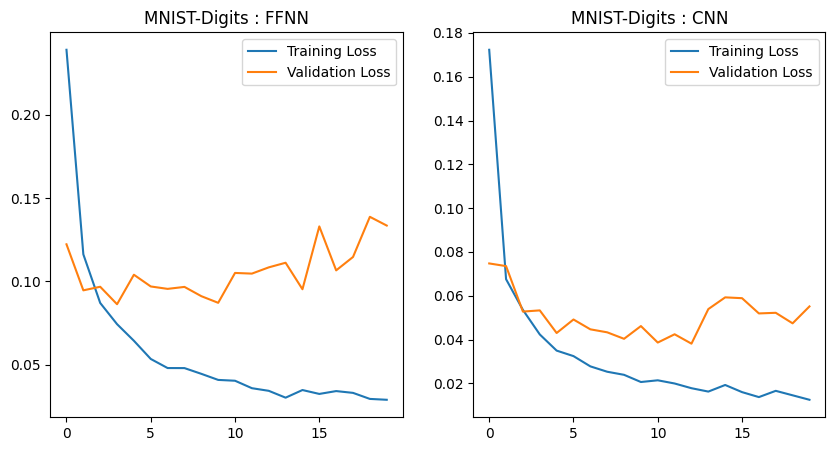

In [ ]:
title=['FFNN','CNN']
model_losses=[m1_loss,m2_loss]
fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('MNIST-Digits : '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [ ]:
def test(model):
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels = images.cuda(),labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        test_loss += loss.item()
        _,pred = torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss = test_loss/len(test_loader)

    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly predicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {i} : {float(100 * class_correct[i] / class_total[i]):.4f}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total)):.4f}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")

    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]))
        ax.set_title("{} for ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

## Visualizing a Test batch with results

### FFNN

For FNet :
Test Loss: 0.07622673404361194
Correctly predicted per class : [970.0, 1123.0, 1012.0, 986.0, 948.0, 869.0, 931.0, 1010.0, 948.0, 979.0], Total correctly predicted : 9776.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 98.9796% where 970 of 980 were predicted correctly
Test Accuracy of class 1 : 98.9427% where 1123 of 1135 were predicted correctly
Test Accuracy of class 2 : 98.0620% where 1012 of 1032 were predicted correctly
Test Accuracy of class 3 : 97.6238% where 986 of 1010 were predicted correctly
Test Accuracy of class 4 : 96.5377% where 948 of 982 were predicted correctly
Test Accuracy of class 5 : 97.4215% where 869 of 892 were predicted correctly
Test Accuracy of class 6 : 97.1816% where 931 of 958 were predicted correctly
Test Accuracy of class 7 : 98.2490% where 1010 of 1028 were predicted correctly
Test Accuracy of class 8 : 97.3306% wh

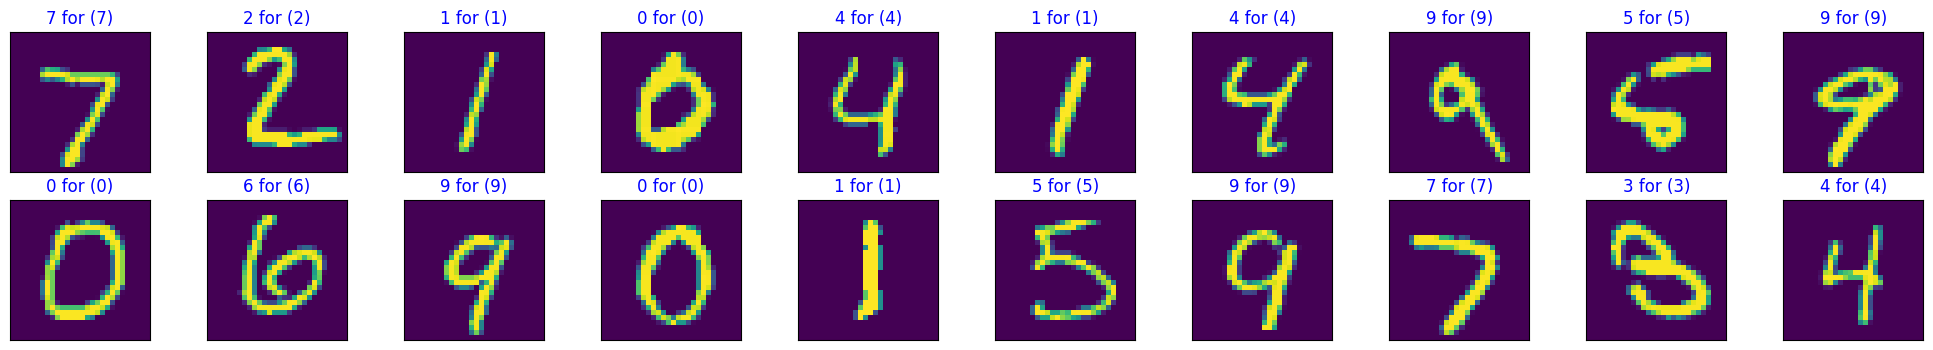

In [ ]:
test(model_1)

Clearly achieved test accuracy of **97.76**%

### CNN

For convNet :
Test Loss: 0.03194080701151193
Correctly predicted per class : [975.0, 1134.0, 1027.0, 1007.0, 974.0, 884.0, 948.0, 1017.0, 968.0, 997.0], Total correctly predicted : 9931.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 99.4898% where 975 of 980 were predicted correctly
Test Accuracy of class 1 : 99.9119% where 1134 of 1135 were predicted correctly
Test Accuracy of class 2 : 99.5155% where 1027 of 1032 were predicted correctly
Test Accuracy of class 3 : 99.7030% where 1007 of 1010 were predicted correctly
Test Accuracy of class 4 : 99.1853% where 974 of 982 were predicted correctly
Test Accuracy of class 5 : 99.1031% where 884 of 892 were predicted correctly
Test Accuracy of class 6 : 98.9562% where 948 of 958 were predicted correctly
Test Accuracy of class 7 : 98.9300% where 1017 of 1028 were predicted correctly
Test Accuracy of class 8 : 99.384

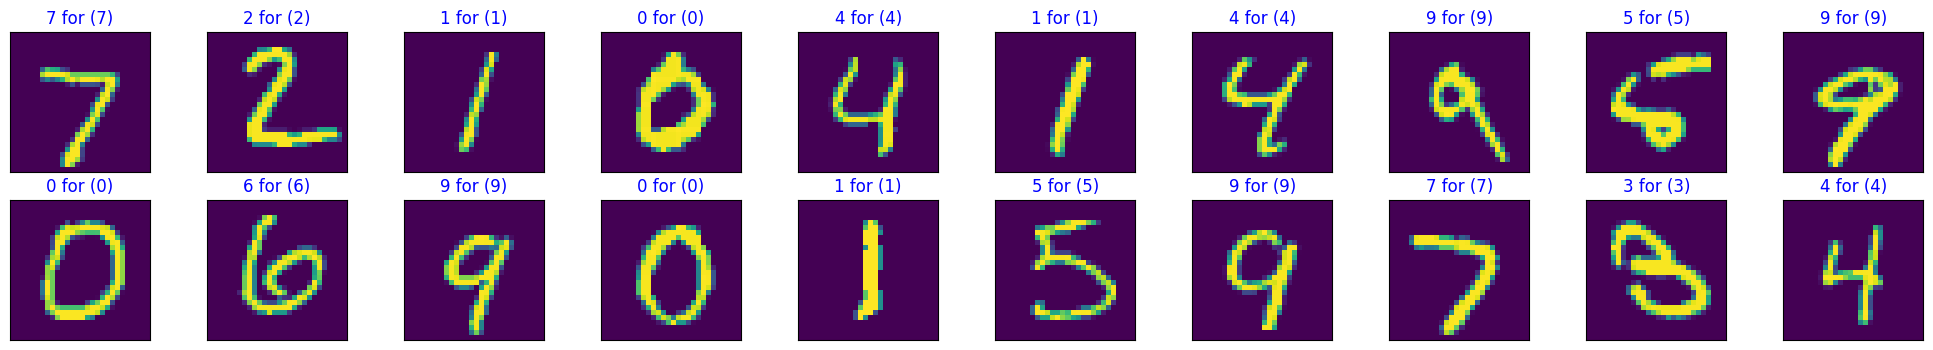

In [ ]:
test(model_2)

Clearly achieved test accuracy of **99.31%**


